# Fuel Analysis

#### Library init and setup

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

#### Data standarization and storage

**Teams data structure**

`teams: dict` - Contains the dict of teams, with a *team* dict per each team

`team: dict` - Contains the team's data in keys, which are:
* `F_TYPE` - Fuel Type
* `FEF` - Fuel Efficiency Factor
* `DISPLACEMENT` - Engine Displacement (cc)
* `ACC_SCORE` - Acceleration event score
* `ACC_DNF` - DNF/DNA in Acceleration event participation
* `END_SCORE` - Endurance event score
* `END_DNF` - DNF/DNA in Endurance event participation

_Note_: Certain teams participated in Fuel Efficiency Event, but not in others, so a key's existence must be validated to avoid errors.

In [3]:
# Dict to contain each team's data in their own dict
teams = {}
fuel_path = "FSAE_2023_results/FSAE_2023_results - Efficiency results.csv"
acc_path = "FSAE_2023_results/FSAE_2023_results - Acceleration event results.csv"
end_path = "FSAE_2023_results/FSAE_2023_results - Endurance event results.csv"
info_path = "FSAE_2023_results/FSAE_2023_results - Team information.csv"

# Loading data of teams in Fuel Efficiency Event into dict
with open(fuel_path) as file:
    reader = csv.DictReader(file)

    for entry in reader:
        # Validate entry if lesser than max time allowed in event
        if float(entry["Average Adjusted Laptime"]) < 197.342:
            FEF_value = entry["Fuel Efficiency Factor"]
            # Cast value if it's != "", set it to 0 otherwise
            FEF = float(FEF_value) if FEF_value != "" else 0
            # Add Fuel type and FEF to team data
            teams[entry["Team"]] = {"F_TYPE": entry["Fuel Type"],"FEF": FEF}

# Loading each team's engine displacement
with open(info_path) as file:
    reader = csv.DictReader(file)

    for entry in reader:
        # Validate whether team participated in Fuel Efficiency Event 
        if entry["Team"] in teams:
            teams[entry["Team"]]["DISCPLACEMENT"] = entry["Engine Displacement (cc)"]

# Loading each team's acceleration score and DNF in said event
with open(acc_path) as file:
    reader = csv.DictReader(file)

    for entry in reader:
        # Validate wether team participated in Fuel Efficiency Event
        if entry["Team"] in teams:
            # Checking DNA/DNA in run
            values = [entry["Run #1 Time"], 
                      entry["Run #2 Time"], 
                      entry["Run #3 Time"],
                      entry["Run #4 Time"]]
            DNF = True if "DNA" in values or "DNF" in values else False

            # Add acceleration score and DNA/DNF data
            teams[entry["Team"]]["ACC_SCORE"] = float(entry["Score"])
            teams[entry["Team"]]["ACC_DNF"] = DNF

# Loading each team's endurance score and DNF in said event
with open(end_path) as file:
    reader = csv.DictReader(file)

    for entry in reader:
        # Validate wether team participated in Fuel Efficiency Event
        if entry["Team"] in teams:
            DNF = True if entry["Adjusted Time"] == "DNF" else False

            # Add endurance score and DNA/DNF data
            teams[entry["Team"]]["END_SCORE"] = float(entry["Endurance Score"])
            teams[entry["Team"]]["END_DNF"] = DNF


### Fuel used against average fuel efficiency factor (FEF)

FEF is calculated with the following formula:

FEF = (Tmin/Tyours) * (CO2min/CO2yours) * (Lapyours^2/Laptotal^2)

Being Tmin and C02min the least metric achieved in the competition, and yours being the one the team got.

Average FEF for each fuel type:
- 93: 0.3805, 22 teams.
- 100: 0.475, 11 teams.
- E85: 0.48, 13 teams.


(0.0, 0.6)

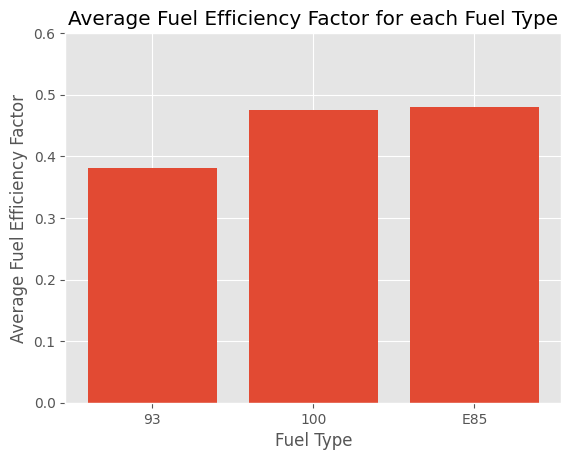

In [46]:
# Calculate average FEF for each fuel type
fuel_types = {"93": [], "100": [], "E85": []}

for team in teams:
    fuel_types[teams[team]["F_TYPE"]].append(teams[team]["FEF"])

print("Average FEF for each fuel type:")

for fuel in fuel_types:
    avrg = np.mean(fuel_types[fuel])
    print(f"- {fuel}: {round(avrg,4)}, {len(fuel_types[fuel])} teams.")
    fuel_types[fuel] = avrg

# Plot average FEF for each fuel type
fig, ax = plt.subplots()
ax.bar(fuel_types.keys(), fuel_types.values())

# Style the plot
ax.set_title("Average Fuel Efficiency Factor for each Fuel Type")
ax.set_xlabel("Fuel Type")
ax.set_ylabel("Average Fuel Efficiency Factor")
ax.set_ylim(0, 0.6)



### * Fuel categorization: Average FEF per engine displacement

 **NOTE:** This is *really* biased, needs more data from previous years to actually categorize properly


Average FEF for each fuel type and engine displacement:

E85:
- 450cc: 0.6017, 3 teams.
- 600cc: 0.3827, 6 teams.

100:
- 600cc: 0.464, 5 teams.
- 636cc: 0.344, 3 teams.

93:
- 600cc: 0.3109, 16 teams.


[None, None, None, None, None, None]

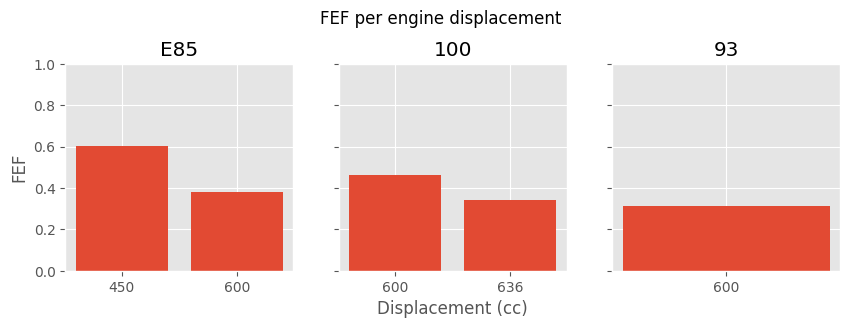

In [7]:
# Dict of fuel types with list of FEF per engine displacement
fuels = {}

# Populate the dict
for team in teams:
    fuel = teams[team]["F_TYPE"]
    displacement = teams[team]["DISCPLACEMENT"]
    fef = teams[team]["FEF"]
    # Initializing the dict and list if not present
    if fuel not in fuels:
        fuels[fuel] = dict()
        
    if displacement not in fuels[fuel]:
        fuels[fuel][displacement] = []
        fuels[fuel][displacement].append(fef)
    else:
        fuels[fuel][displacement].append(fef)

# Calculate average (more than 2 occurences) FEF for each fuel type and engine displacement
print("\nAverage FEF for each fuel type and engine displacement:")

for fuel in fuels:
    print(f"\n{fuel}:")
    for displacement in fuels[fuel]:
        # Compute averages
        if len(fuels[fuel][displacement]) > 2:
            avrg = np.mean(fuels[fuel][displacement])
            print(f"- {displacement}cc: {round(avrg,4)}, {len(fuels[fuel][displacement])} teams.")
            fuels[fuel][displacement] = avrg

# Sort the dict by engine displacement
for fuel in fuels:
    fuels[fuel] = dict(sorted(fuels[fuel].items()))

# Graph the FEF
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3))

fig.subplots_adjust(top=0.8)
fig.suptitle("FEF per engine displacement")

# E85
E85 = fuels["E85"]
E85_X = [x for x in E85.keys() if isinstance(E85[x], float)]
E85_Y = [E85[x] for x in E85_X]

ax1.set_title("E85")
ax1.set_ylabel("FEF")

ax1.bar(E85_X, E85_Y)

#100
f100 = fuels["100"]
f100_X = [x for x in f100.keys() if isinstance(f100[x], float)]
f100_Y = [f100[x] for x in f100_X]

ax2.set_title("100")
ax2.set_xlabel("Displacement (cc)")

ax2.bar(f100_X, f100_Y)

#93
f93 = fuels["93"]
f93_X = [x for x in f93.keys() if isinstance(f93[x], float)]
f93_Y = [f93[x] for x in f93_X]

ax3.set_title("93")

ax3.bar(f93_X, f93_Y)

# Style the plots with same y axis
# Set up y axis
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

# Set y axis ticks to be visible only on the first plot
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)


### FEF - Performance scores and Reliability per event (Acceleration, Endurance)